# Explanation of the Function Evaluator

In this notebook, we showcase how the function evaluator is used in `lcm`, and how it
works. Before we dive into the details, let us consider what is does on a high level.

## Motivation

Consider the last period of a finite dynamic programming problem. The value function
array for this period corresponds to the maximal utility in each state. If the
state-space is discretized into states $(x_1, \ldots, x_p)$, the value function array
(in the last period) $V_T$ is a $p$-dimensional array, where $V_{T, i} = V_T(x_i)$ is
the maximal utility the agent can achieve in state $x_i$.

Consider now the Bellman equation for the second-to last period:

$$
V_{T-1}(x) =
    \max_{a} \left\{u(x, a) + \mathbb{E}_{T-1}\left[V_T(x') \mid x, a\right] \right\},
$$

where $a$ denotes the action, and $x', x$ denote the next and current state,
respectively.

Depending on the solution algorithm, or the method to approximate the expectation, we
may need to evaluate the function $V_T$ at a different set of points than the
pre-calculated grid points $(x_1, \ldots, x_p)$.

Ideally, we would like to treat $V_T$ as an analytical function that can be evaluated
at any valid state $x$, ignoring the discretization. This is what the function evaluator
does.
                                                        

### Example

As an example, consider a stripped down version of the deterministic model from
Iskhakov et al. (2017), which removes the absorbing retirement filter and the lagged
retirement state compared to the original model (this version can be found in the
`tests/test_models/deterministic.py` module). Here we also use a coarser grid to
showcase the behavior of the function evaluator.

In [66]:
import jax.numpy as jnp


def utility(consumption, working, disutility_of_work):
    return jnp.log(consumption) - disutility_of_work * working


def labor_income(working, wage):
    return working * wage


def working(retirement):
    return 1 - retirement


def wage(age):
    return 1 + 0.1 * age


def age(_period):
    return _period + 18


def next_wealth(wealth, consumption, labor_income, interest_rate):
    return (1 + interest_rate) * (wealth - consumption) + labor_income


def consumption_constraint(consumption, wealth):
    return consumption <= wealth


model = {
    "description": (
        "Starts from Iskhakov et al. (2017), removes filters and the lagged_retirement "
        "state, and adds wage function that depends on age."
    ),
    "functions": {
        "utility": utility,
        "next_wealth": next_wealth,
        "consumption_constraint": consumption_constraint,
        "labor_income": labor_income,
        "working": working,
        "wage": wage,
        "age": age,
    },
    "choices": {
        "retirement": {"options": [0, 1]},
        "consumption": {
            "grid_type": "linspace",
            "start": 1,
            "stop": 400,
            "n_points": 20,
        },
    },
    "states": {
        "wealth": {
            "grid_type": "linspace",
            "start": 1,
            "stop": 400,
            "n_points": 10,
        },
    },
    "n_periods": 2,
}


params = {
    "beta": 0.95,
    "utility": {"disutility_of_work": 0.25},
    "next_wealth": {
        "interest_rate": 0.05,
    },
}

To generate the correct JAX grids from this model specification, let us process the
model manually. Note that normally, this is done under the hood in `lcm`.

In [76]:
from lcm.process_model import process_model

processed_model = process_model(model)

#### Last period value function array

To compute the value function array in the last period, we first generate the utility
and feasibility function that depends only on state and choice variables, and then
compute the maximum over all feasible actions.

In [77]:
from lcm.model_functions import get_current_u_and_f

u_and_f = get_current_u_and_f(processed_model)
u_and_f?

Signature: u_and_f(consumption, params, retirement, wealth)
Docstring: <no docstring>
File:      ~/sciebo-thinky/lcm/.pixi/envs/default/lib/python3.12/site-packages/dags/signature.py
Type:      function

We can then evaluate `u_and_f` on scalar values. Notice that in the below example, the
action is not feasible since the consumption constraint restricts a consumption level
that is higher than the wealth level.

In [70]:
_u, _f = u_and_f(
    consumption=100.5,
    retirement=0,
    wealth=50.25,
    params=params,
)

print(f"Utility: {_u}, feasible: {_f}")

Utility: 4.3601579666137695, feasible: False


To evaluate `u_and_f` on the whole state-choice-space we need to use `lcm.productmap`,
which allows us to pass in grids for each variable.

In [80]:
processed_model.grids.keys()

dict_keys(['retirement', 'wealth', 'consumption'])

In [83]:
from lcm.dispatchers import productmap

u_and_f_mapped = productmap(u_and_f, variables=["wealth", "consumption", "retirement"])

u, f = u_and_f_mapped(**processed_model.grids, params=params)

print(f"Length of (retirement, consumption, wealth) grids: {u.shape}")

Length of (retirement, consumption, wealth) grids: (10, 20, 2)


Now we can compute the value function array by taking the maximal utility over all
feasible actions (axis 1 and 2 correspond to the consumption and retirement dimensions
respectively).

In [72]:
vf_arr = jnp.max(u, axis=(1, 2), where=f, initial=-jnp.inf)
vf_arr.shape

(10,)

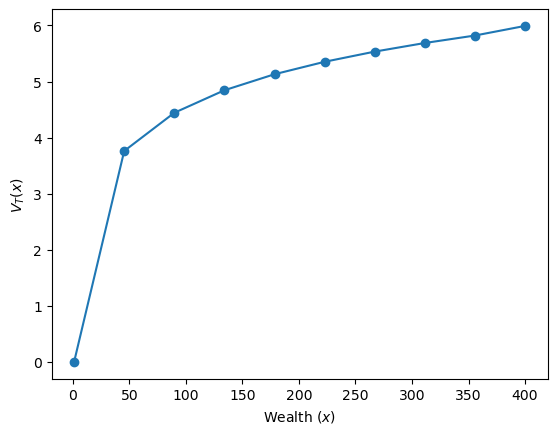

In [95]:
import matplotlib.pyplot as plt

wealth_grid = processed_model.grids["wealth"]

plt.plot(wealth_grid, vf_arr)
plt.scatter(wealth_grid, vf_arr)
plt.xlabel("Wealth ($x$)")
plt.ylabel("$V_T(x)$")
plt.show()

#### Interpolation

What happens now if we want to know the value of $V_T$ at 25 or 75? We need to perform
some kind of interpolation. This is where the function evaluator comes into play, which
returns pre-calculated values if evaluated on a grid point, and linearly interpolated
values otherwise.

To optimally utilize the structure of grid when interpolating, the function evaluator
requires information on the state space.

In [122]:
from lcm.state_space import create_state_choice_space

# the space info object contains information on the grid structure etc.
_, space_info, *_ = create_state_choice_space(
    model=processed_model,
    period=1,
    is_last_period=True,
    jit_filter=False,
)

In [101]:
from functools import partial

from lcm.function_evaluator import get_function_evaluator

_value_function = get_function_evaluator(
    space_info=space_info,
    data_name="vf_arr",  # this will become an argument of the returned function
)

# We need to apply productmap and pass in the pre-calculated value function array
value_function = partial(
    productmap(_value_function, variables=["wealth"]),
    vf_arr=vf_arr,
)

#### Visualizing the results

Let us now plot the value function again. Notice that the line that connects the points
generated by matplotlib is a linear interpolation. We also evaluate the value function
on points that are not pre-calculated. We would like to see that those points lie on the
line generated by matplotlib.


In [141]:
wealth_grid = processed_model.grids["wealth"]
new_wealth_values = jnp.array([10, 25, 75, 210, 300])

v_on_grid = value_function(wealth=wealth_grid)
v_on_new_values = value_function(wealth=new_wealth_values)

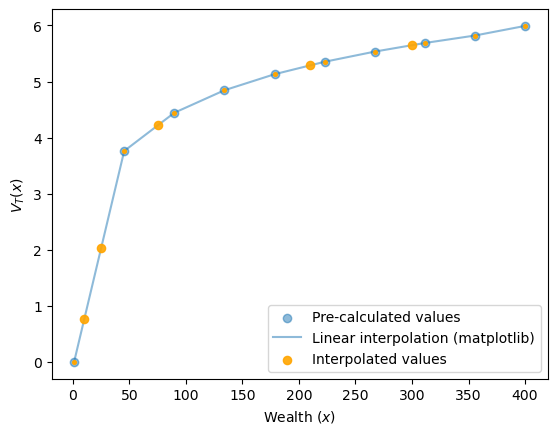

In [142]:
import matplotlib.pyplot as plt

plt.scatter(wealth_grid, vf_arr, alpha=0.5, zorder=-1, label="Pre-calculated values")
plt.plot(
    wealth_grid,
    vf_arr,
    alpha=0.5,
    zorder=-1,
    label="Linear interpolation (matplotlib)",
)
plt.scatter(wealth_grid, v_on_grid, color="orange", s=7)
plt.scatter(
    new_wealth_values,
    v_on_new_values,
    color="orange",
    s=35,
    alpha=0.9,
    label="Interpolated values",
)
plt.xlabel("Wealth ($x$)")
plt.ylabel("$V_T(x)$")
plt.legend()
plt.show()